In [3]:
cd ".."

/Users/vbp/Dropbox (Personal)/research/github-projects/inelastic-capital/code


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
data_folder = "/Users/vbp/Dropbox (Personal)/research/research-data/inelastic-capital-data/"
pd.set_option('display.max_columns', None)

In [127]:
warnings.filterwarnings("ignore")


In [147]:
ccm = pd.read_csv(os.path.join(data_folder, "raw", "wrds", "Compustat_Fundamentals_Yearls_allyears.csv"))
link = pd.read_csv(os.path.join(data_folder, "raw", "wrds", "CRSP_CCM_link.csv"))
crsp = pd.read_csv(os.path.join(data_folder, "raw", "wrds", "CRSP_monthly_prices.csv"))

In [148]:
ccm['date'] = pd.to_datetime(ccm['datadate'], format='%Y-%m-%d')
ccm['year'] = ccm['date'].dt.year
ccm = ccm.drop_duplicates(subset=['gvkey','year'])

crsp.columns = crsp.columns.str.lower()
crsp['date'] = pd.to_datetime(crsp['date'], format='%Y-%m-%d')
crsp = crsp.drop_duplicates(subset=['permno','date'])
crsp['year'] = crsp['date'].dt.year
crsp['month'] = crsp['date'].dt.month

crsp['padj'] = crsp['prc'] / crsp['cfacpr']
crsp['mv'] = crsp['prc'] * crsp['shrout']

crsp['ret'] = pd.to_numeric(crsp['ret'], errors='coerce')
crsp['retx'] = pd.to_numeric(crsp['retx'], errors='coerce')

crsp['log_ret'] = np.log(1 + crsp['ret'])
crsp['log_retx'] = np.log(1 + crsp['retx'])

crsp = crsp.groupby(['year', 'permno']).agg({'log_ret': 'sum', 'log_retx': 'sum', 'padj': 'mean', 'shrout':'mean', 'cfacpr':'mean', 'mv':'mean'}).reset_index()


In [186]:
link = link.rename(columns={'LPERMNO': 'permno'})[['gvkey','permno']]
df = crsp.merge(link, on='permno', how='inner')
df = df.merge(ccm, on=['gvkey','year'], how='inner')

In [187]:
df = df.drop_duplicates(subset=['permno','year'])
df = df.sort_values(by=['permno','year'])

In [188]:
df['capx_sh'] = np.where(df.revt > 0, df.capx / df.revt, np.nan)
df['xrd_sh'] = np.where(df.revt > 0, df.xrd / df.revt, np.nan)
df['ret'] = np.exp(df.log_ret) - 1
df['retx'] = np.exp(df.log_retx) - 1
df['log_ret'] = np.log(1 + df.ret)
df['log_retx'] = np.log(1 + df.retx)

In [190]:
df['log_capx'] = np.where(df.capx > 0, np.log(df.capx), np.nan)
df = get_lag(df, shift_col='log_capx', group_cols=['permno'])
df['d_log_capx'] = df.log_capx - df.L1_log_capx

In [192]:
df_agg = df.groupby(['permno'])[
        [
        'ret',
        'retx',
        'log_ret',
        'log_retx',
        'padj',
        'act',
        'at',
        'ch',
        'lct',
        'lt',
        'ppegt',
        'ppent',
        'tsa',
        'cga',
        'cogs',
        'revt',
        'sale',
        'xrd',
        'aqc',
        'capx',
        'cshr',
        'emp',
        'mkvalt',
        'capx_sh',
        'xrd_sh',
        'mv',
        'd_log_capx'
        ]
].mean().reset_index()

In [165]:
for col in [
        'padj',
        'act',
        'at',
        'ch',
        'lct',
        'lt',
        'ppegt',
        'ppent',
        'tsa',
        'cga',
        'cogs',
        'revt',
        'sale',
        'xrd',
        'aqc',
        'capx',
        'cshr',
        'emp',
        'mv']:
    df_agg[f'log_{col}'] = np.where(df_agg[col] > 0, np.log(df_agg[col]), np.nan)

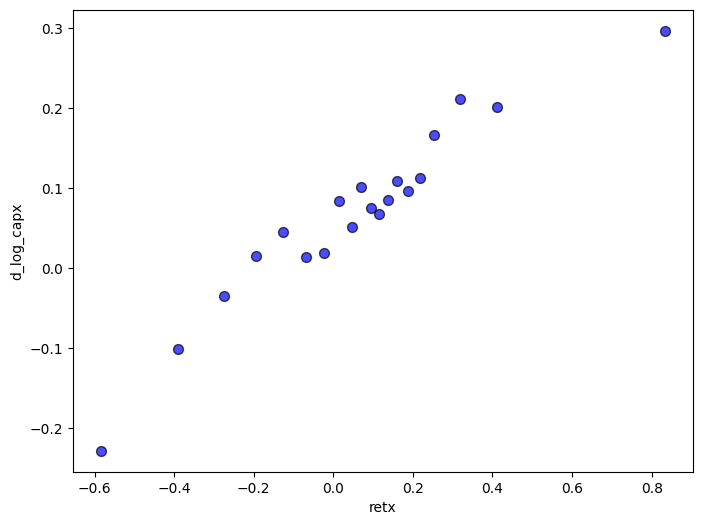

In [193]:
binscatter_plot(df_agg, x_var='retx', y_var='d_log_capx', weights='mv')

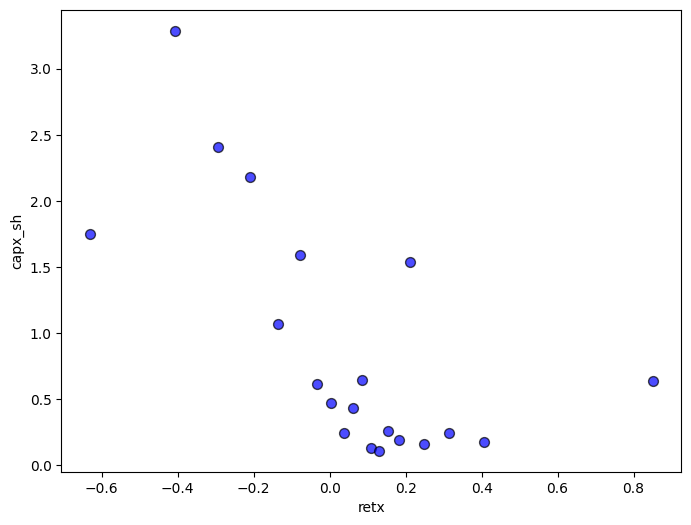

In [175]:
# Binscatter of log_ret vs invest
binscatter_plot(df_agg, x_var='retx', y_var='capx_sh', weights='mv')

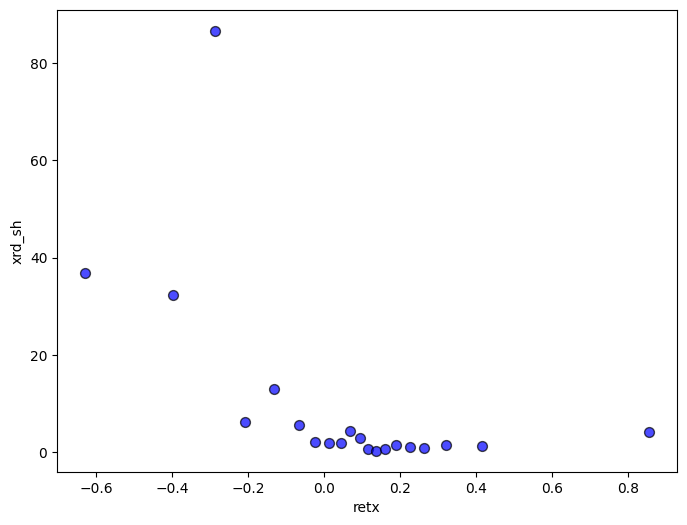

In [177]:
binscatter_plot(df_agg, x_var='retx', y_var='xrd_sh', weights='mv')

# NBER CES Manufacturing Data

In [83]:
df = pd.read_csv(os.path.join(data_folder, "raw", "nber-manufacturing-data", "nberces5818v1_n2012.csv"))
df = df[df.year!=2018]

naics_map = {
    "311": "Food",
    "312": "Beverage & Tobacco",
    "313": "Textiles (Mills)",
    "314": "Textiles (Products)",
    "315": "Apparel",
    "316": "Leather",
    "321": "Wood Products",
    "322": "Paper",
    "323": "Printing",
    "324": "Petroleum & Coal",
    "325": "Chemicals",
    "326": "Plastics & Rubber",
    "327": "Nonmetallic Minerals",
    "331": "Primary Metals",
    "332": "Fabricated Metals",
    "333": "Machinery",
    "334": "Computers & Electronics",
    "335": "Electrical Equip & Appliances",
    "336": "Transportation Equipment",
    "337": "Furniture",
    "339": "Miscellaneous"
}

df['naics3'] = df.naics.astype(str).str.slice(0, 3)
df['naics_name'] = df.naics3.map(naics_map)

df_agg = df.groupby(['naics3','naics_name','year'])[
    [
        'emp',
        'pay',
        'prode',
        'prodh',
        'prodw',
        'vship',
        'matcost',
        'vadd',
        'invest',
        'invent',
        'energy',
        'cap',
        'equip',
        'plant',
        'piship',
        'pimat',
        'piinv',
        'pien',
    ]
].sum().reset_index()

In [84]:
for col in ['invest', 'invent', 'energy', 'cap', 'equip', 'plant', 'piship', 'pimat', 'piinv', 'pien']:
    df_agg[f'log_{col}'] = np.where(df_agg[col] > 0, np.log(df_agg[col]), np.nan)
    df_agg = get_lag(df_agg, shift_col=col, group_cols=['naics3'])
    df_agg[f'd_log_{col}'] = df_agg[f'log_{col}'] - np.where(df_agg[f'L1_{col}'] > 0, np.log(df_agg[f'L1_{col}']), np.nan)
    
    df_agg[f'{col}_per_worker'] = df_agg[col] / df_agg['emp']
    df_agg[f'{col}_salesh'] = df_agg[col] / df_agg['vship']

df_agg['invest_rate'] = df_agg['invest'] / df_agg['cap']

/Users/vbp/anaconda3/envs/econ/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/vbp/anaconda3/envs/econ/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/vbp/anaconda3/envs/econ/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/vbp/anaconda3/envs/econ/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Get cumulative log change 
df_agg['cum_d_log_invest'] = df_agg.groupby('naics3')['d_log_invest'].cumsum()

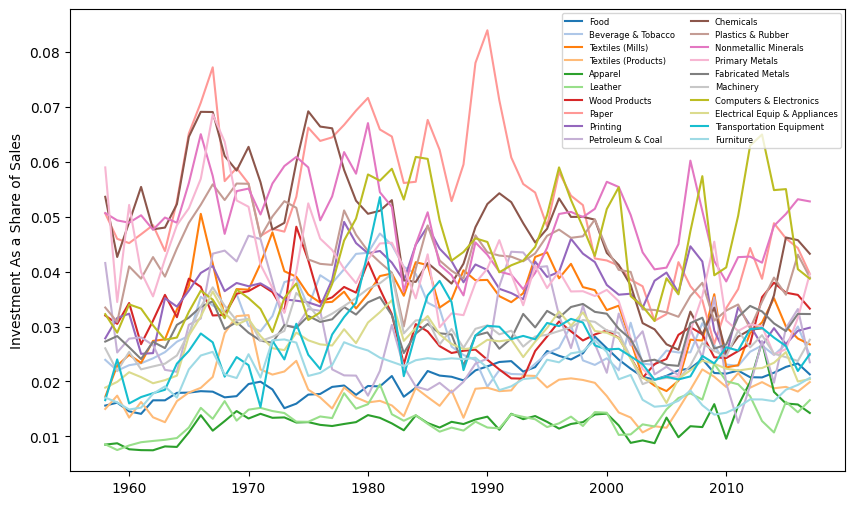

In [69]:
# Set a different colormap for the entire plot
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

fig, ax = plt.subplots(figsize=(10, 6))
for industry in df_agg.naics_name.unique():
    if industry == 'Miscellaneous':
        continue
    ax.plot(df_agg[df_agg.naics_name == industry].year, 
            df_agg[df_agg.naics_name == industry].invest_salesh, 
            label=industry)
plt.legend(ncol=2, fontsize=6, loc='best')
ax.set_ylabel('Investment As a Share of Sales')
plt.show()

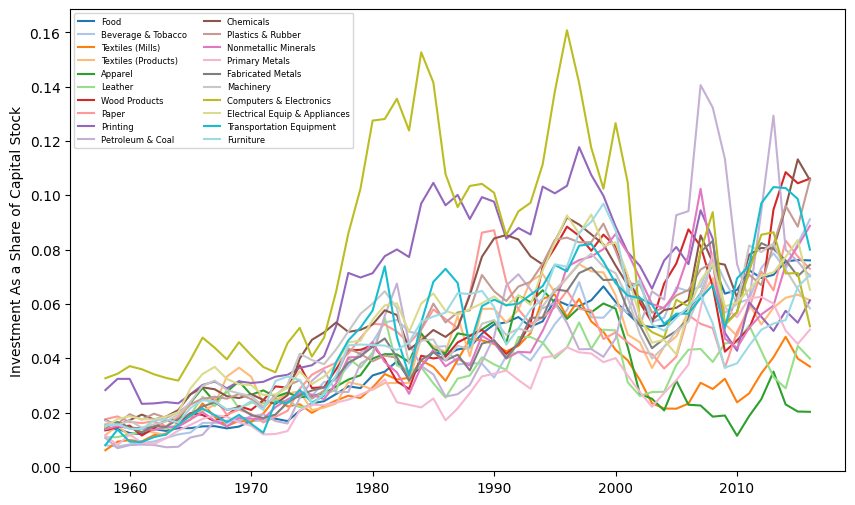

In [72]:
# Set a different colormap for the entire plot
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

fig, ax = plt.subplots(figsize=(10, 6))
for industry in df_agg.naics_name.unique():
    if industry == 'Miscellaneous':
        continue
    ax.plot(df_agg[df_agg.naics_name == industry].year, 
            df_agg[df_agg.naics_name == industry].invest_rate, 
            label=industry)
plt.legend(ncol=2, fontsize=6, loc='best')
ax.set_ylabel('Investment As a Share of Capital Stock')
plt.show()

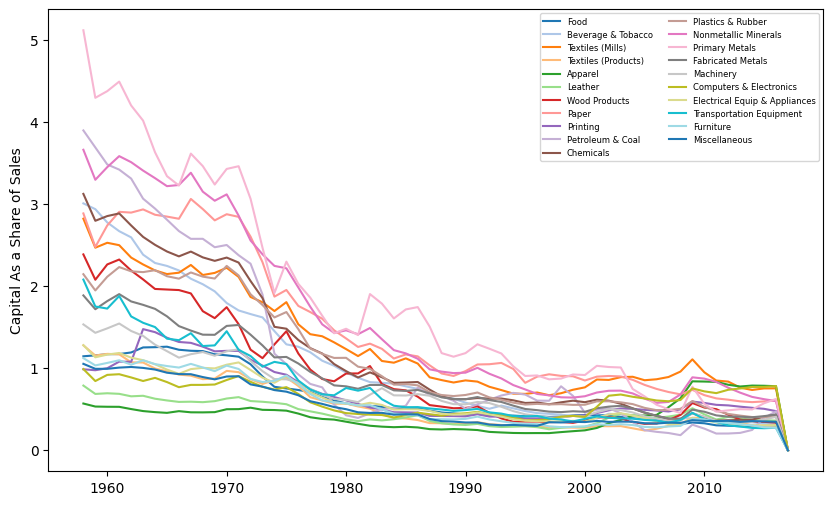

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
for industry in df_agg.naics_name.unique():
    ax.plot(df_agg[df_agg.naics_name == industry].year, df_agg[df_agg.naics_name == industry].cap_salesh, label=industry)
plt.legend(ncol=2, fontsize=6, loc='best')
ax.set_ylabel('Capital As a Share of Sales')
plt.show()

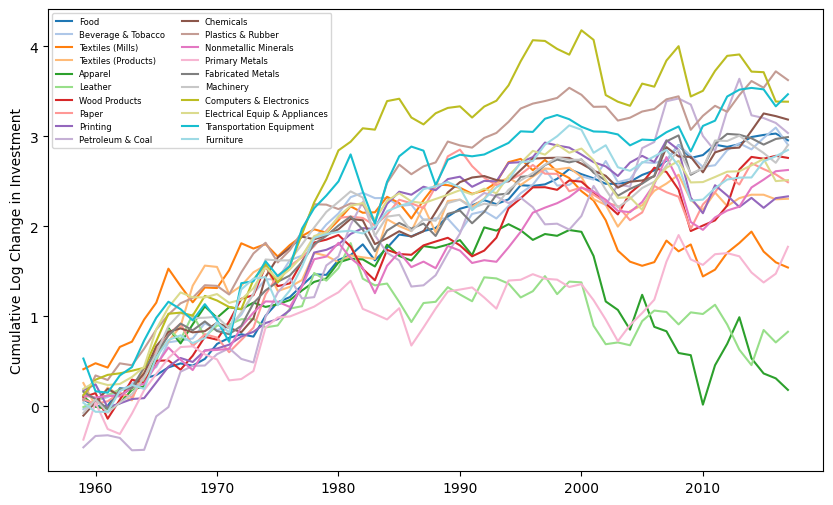

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
for industry in df_agg.naics_name.unique():
    if industry == 'Miscellaneous':
        continue
    ax.plot(df_agg[df_agg.naics_name == industry].year, 
            df_agg[df_agg.naics_name == industry].cum_d_log_invest, 
            label=industry)
plt.legend(ncol=2, fontsize=6, loc='best')
ax.set_ylabel('Cumulative Log Change in Investment')
plt.show()